# Surrogate Construction for Genz Functions

This notebook constructs a PC surrogate for Genz functions using full and sparse quadrature, regression, and Bayesian Compressive Sensing and gives the normalized root mean square error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
import numpy as np
import math  
from scipy.stats import qmc
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
nord = 3            # Order of the PCE
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
param = nord+1      # Number of quadrature points per dimension for full quadrature or level for sparse quadrature
nSam = 10000        # Number of random samples
ndim = 6            # Number of dimensions
model= 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

## Quadrature and Galerkin Projection
#### Full Quadrature

First, we instantiate the PC object with full quadrature.

In [3]:
pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha,pc_beta)
pc_model.SetQuadRule(pc_type, 'full', param)

Then, we get a NumPy array of quadrature points, qdpts. Totquat is the total number of quadrature points.

In [4]:
qdpts, totquat= pce_tools.UQTkGetQuadPoints(pc_model)

We evaluate the forward model, the chosen Genz function. The input parameters for the model are all 1, for simpicity, and must be in the form of an array of dimension ndim+1, where the first entry is the shift.
We obtain f_evals, an array of evaluations.

In [5]:
f_evals=func(qdpts,model,np.ones(ndim+1))

We obtain the PC coefficents with Galerkin projection.

In [6]:
c_k = pce_tools.UQTkGalerkinProjection(pc_model,f_evals)

We then generate test samples in [-1, 1] at which to evaluate the PCE. These are the points at which we are checking the accuracy of the surrogate.

In [7]:
rng = qmc.LatinHypercube(d=ndim, seed=42) # random number generator
x_test=2*rng.random(n=nSam)-1 #draw n samples from [-1,1]
pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,x_test)

We find the actual values of the model at each test sample and use that to calculate the NRMS error between the surrogate and model.

In [8]:
y_test=func(x_test,model,np.ones(ndim+1))
MSE = np.square(np.subtract(y_test,pce_evals)).mean()
RMSE = math.sqrt(MSE)
NRMSE = RMSE/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a full PC surrogate of order", nord, "is")
NRMSE

The NRMS error between a 6 -dimensional genz_osc function and a full PC surrogate of order 3 is


0.04172611337356407

#### Sparse Quadrature
We repeat the process with sparse quadrature.

In [9]:
pc_model2 = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
pc_model2.SetQuadRule(pc_type, 'sparse', param)
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)
f_evals2 = func(qdpts2,model,np.ones(ndim+1))
c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,f_evals2)
x_test2= 2*rng.random(n=nSam)-1
pce_evals2 = pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,x_test2)
y_test2 = func(x_test2,model,np.ones(ndim+1))
MSE2 = np.square(np.subtract(y_test2, pce_evals2)).mean()
RMSE2 = math.sqrt(MSE2)
NRMSE2 = RMSE2/np.abs(y_test2.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a sparse PC surrogate of order", nord, "is")
NRMSE2

The NRMS error between a 6 -dimensional genz_osc function and a sparse PC surrogate of order 3 is


0.040385444287216805

## Regression

Similarly, we define a PC object for regression and then get a collection of random sample points in [-1,1].

In [10]:
# Instantiate PC object
pc_model3 = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Training points
nTrain=pc_model3.GetNumberPCTerms() # number of sample points equal to the number of basis terms
x_train3=2*rng.random(n=nTrain)-1
y_train3=func(x_train3,model,np.ones(ndim+1))

Then, we use regression to find the PC coefficients and evaluate the PC at nSam sample points. The error between these evaluations and the actual model is determined.

In [11]:
#Regression
c_k3 = pce_tools.UQTkRegression(pc_model3, y_train3, x_train3)

# Validation points
x_test3=2*rng.random(n=nSam)-1
pce_evals3=pce_tools.UQTkEvaluatePCE(pc_model3,c_k3,x_test3)

#Error
y_test3=func(x_test3, model, np.ones(ndim+1))
MSE3 = np.square(np.subtract(y_test3, pce_evals3)).mean()
RMSE3=math.sqrt(MSE3)
NRMSE3=RMSE3/np.abs(y_test3.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a regression-based PC surrogate of order", nord, "is")
NRMSE3

The NRMS error between a 6 -dimensional genz_osc function and a regression-based PC surrogate of order 3 is


0.27815711396555615

#### BCS
First, we set the BCS-specific inputs.

In [12]:
# BCS parameters
niter = 2              # Number of iterations to run, must be > 0
eta = 1/np.power(10,[i for i in range(1,16)])  # Threshold for stopping the algorithm
ntry = 3               # Number of splits for cross-validation of the retained basis terms 
eta_folds = 10          # Number of folds to use for eta cross-validation                          
mindex_growth = 'nonconservative'   # Method for basis growth; options are "conservative," "nonconservative," or None
regparams = None       # Regularization weights (provide an array or value); if None, they are autopopulated
sigma = 1e-8           # Inital noise variance; updated in BCS
trval_frac = None      # Fraction of total data to use in each split
npccut = None          # Maximum number of PC coefficients to retain
pcf_thr = None         # Minimum value (by magnitude) for PC coefficients
verbose = 0            # Flag for print statements
eta_growth = False     # Flag for using basis growth in eta optimization
eta_plot = True        # Flag to show error plot for eta selection 

Then, we generate the training data.

In [13]:
pc_model4 = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
nTrain4=pc_model4.GetNumberPCTerms() # number of sample points equal to the number of terms in a full basis set
x_train4=2*rng.random(n=nTrain4)-1
y_train4=func(x_train4, model, np.ones(ndim+1))

The NRMS error between a 6 -dimensional genz_osc function and a BCS-based PC surrogate of order 3 is


0.13326462691307528

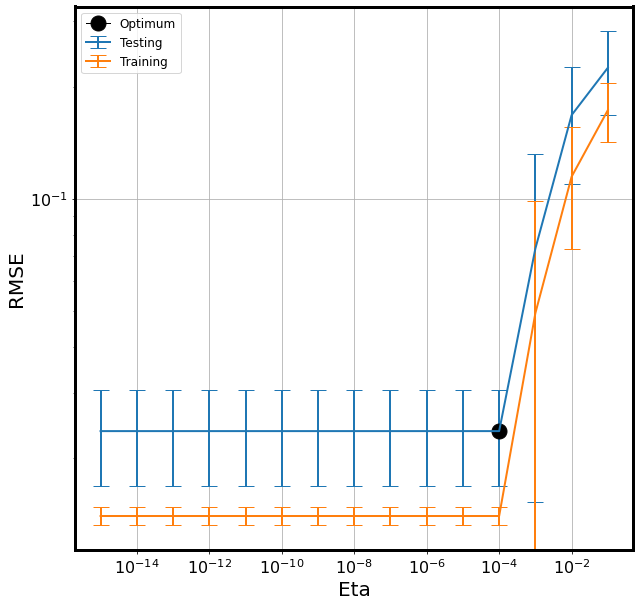

In [14]:
# PC object with the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# BCS
pc_final, c_k4 = pce_tools.UQTkBCS(pc_start, x_train4, y_train4, eta, niter, mindex_growth, ntry, eta_folds, eta_growth, eta_plot, regparams, sigma, trval_frac, npccut, pcf_thr, verbose)
# Evaluate PCE with the final basis
x_test4=2*rng.random(n=nSam)-1
pce_evals4=pce_tools.UQTkEvaluatePCE(pc_final,c_k4,x_test4)

# Error
y_test4=func(x_test4,model,np.ones(ndim+1))
MSE4 = np.square(np.subtract(y_test4,pce_evals4)).mean()
RMSE4=math.sqrt(MSE4)
NRMSE4=RMSE4/np.abs(y_test2.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of order", nord, "is")
NRMSE4

## Summary
This table displays the NRMS Error for each method.

In [15]:
pd.DataFrame(data=[NRMSE, NRMSE2, NRMSE3, NRMSE4], columns=['NRMSE'], index=['Full Galerkin', 'Sparse Galerkin','Regression', 'BCS'])

,NRMSE
Full Galerkin,0.041726
Sparse Galerkin,0.040385
Regression,0.278157
BCS,0.133265
